In [2]:
import pandas as pd
import os
from typing import Any
from datetime import timedelta


from preprocessing import DateTimeFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sklearn.base import BaseEstimator

import joblib

# Load data

In [3]:
script_dir = os.path.dirname("__file__")  # the cwd relative path of the script file

# Bhopal dataset 
bhopal_ds_name = "data/bhopal_month_agg_final.csv"
rel_to_bhopal_ds = os.path.join(script_dir, bhopal_ds_name)
df_bhopal = pd.read_csv(rel_to_bhopal_ds)
df_bhopal.index = pd.to_datetime(df_bhopal.index)


# Algiers dataset
algeria_ds_name = "data/algeria_month_agg_final.csv"
rel_to_algeria_ds = os.path.join(script_dir, algeria_ds_name)
df_algeria = pd.read_csv(rel_to_algeria_ds)
df_algeria.index = pd.to_datetime(df_algeria.index)


<Axes: >

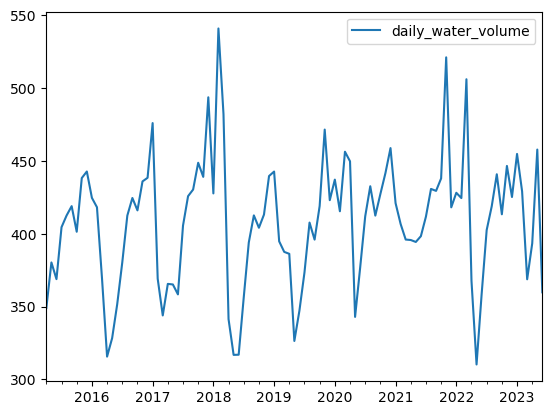

In [4]:
df_algeria.plot()

# Preprocessing functions

In [9]:
LAG_SIZE = 3
TARGET = 'daily_water_volume'

In [5]:
def preprocessing_data(df: pd.DataFrame, target_column: str, target: bool = True) -> Any:
    """
    Perform preprocessing on the input DataFrame.

    Parameters:
    df : pd.DataFrame
        The input DataFrame containing the data.
    target_column : str
        name of target column
    target : bool, optional
        Whether to include the target variable target in the output.

    Returns:
    Any
        If target is True, returns a tuple containing the preprocessed features DataFrame
        and the target Series. If target is False, returns the preprocessed features DataFrame only.
    """
    
    # Features computed from the target.
    # Compute lag and window features.
    lag_list = [i for i in range(1, LAG_SIZE+1)]
    window_list = [[1, i] for i in range(2, LAG_SIZE+1)]
    lag_window_feats = WindowSummarizer(
        lag_feature={
            "lag": lag_list,  # Lag features.
            "mean": window_list,  # [[lag, window size]]
            "min": window_list,  # [[lag, window size]]
            "max": window_list,  # [[lag, window size]]
            "sum": window_list,  # [[lag, window size]]
            "var": window_list,  # [[lag, window size]]
        },
        #truncate="bfill",  # Backfill missing values from lagging and windowing.
    )
    df_lag = lag_window_feats.fit_transform(df[target_column])     
    
    # Compute Time-Features 
    dtf = DateTimeFeatures()
    df_dtf = dtf.fit_transform(df)
    
    # Concatenate all together
    df_concat = pd.concat([df_dtf, df_lag], axis=1)
    if target: 
        y = df_concat[target_column]
        df_concat.drop([target_column], axis=1, inplace=True)
        df_concat.dropna(axis=0, inplace=True)
        y = y[-df_concat.shape[0]:]
        return df_concat, y
    else:
        df_concat.drop([target_column], axis=1, inplace=True)
        df_concat.dropna(axis=0, inplace=True)
        return df_concat

In [6]:
def recursive_multi_step_forecasting_monthly(X: pd.DataFrame, target_column: str, model, days: int = 100) -> pd.DataFrame:
    """
    Perform multi-step recursive forecasting using the provided model.

    Args:
        X (pd.DataFrame): Historical data for forecasting.
        target_column (str): Name of the target column to forecast.
        model: Trained forecasting model.
        days (int): Number of days to forecast.

    Returns:
        pd.DataFrame: DataFrame containing forecasted values.
    """

    # Create an empty DataFrame with the date range for forecasting as index
    # Initialize the target column with zeros.
    start_date = X[-1:].index.date[0] + timedelta(days=1)
    end_date = start_date + timedelta(days=days)
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    empty_df = pd.DataFrame(index=date_range)
    empty_df[target_column] = 0
    
    # Include previous values required for lag features
    df_forecast = pd.concat([X[-LAG_SIZE:], empty_df], axis=0)
    
    # Walk through the empty DataFrame for forecasting
    # Predicting the next value based on historical data
    # Updating the DataFrame with the predicted value
    for index, row in empty_df.iterrows():
        X_input = preprocessing_data(df_forecast[:index], target_column, False)
        prediction = model.predict(X_input)
        df_forecast.loc[index] = prediction[-1]
    return df_forecast[LAG_SIZE:]

In [7]:
model_name_algeria = "models/RandomForestRegressor.joblib"
rel_to_model_algeria = os.path.join(script_dir, model_name_algeria)
rfr_algeria = joblib.load(rel_to_model_algeria)

<Axes: >

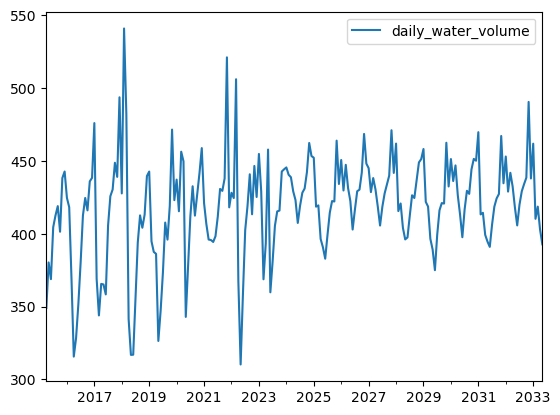

In [48]:
df_forecast = recursive_multi_step_forecasting_monthly(df_algeria, 'daily_water_volume', rfr_algeria, 365*10)
df_algeria_and_forecast = pd.concat([df_algeria, df_forecast], axis=0)
df_algeria_and_forecast.plot()

In [17]:
model_name_bhopal = "models/RandomForestRegressorBhopal.joblib"
rel_to_model_bhopal = os.path.join(script_dir, model_name_bhopal)
rfr_bhopal = joblib.load(rel_to_model_bhopal)

<Axes: >

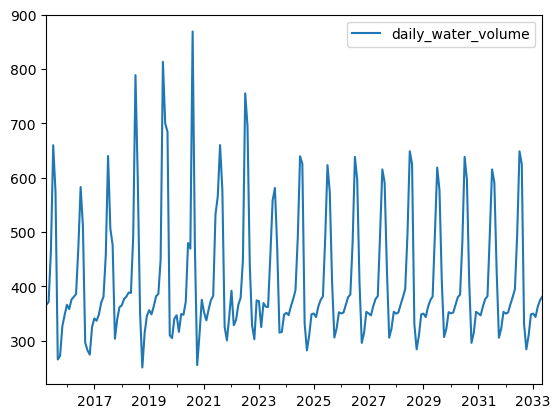

In [18]:
df_forecast_bhopal = recursive_multi_step_forecasting_monthly(df_bhopal, 'daily_water_volume', rfr_bhopal, 365*10)
df_bhopal_and_forecast = pd.concat([df_bhopal, df_forecast_bhopal], axis=0)
df_bhopal_and_forecast.plot()

# Construct Water Availability

In [19]:
# add population data

In [28]:
# Bhopal population
bhopal_population = "data/Bhopal-population-2023-11-22.csv"  
rel_to_bhopal_population = os.path.join(script_dir, bhopal_population)
df_bhopal_population = pd.read_csv(rel_to_bhopal_population)
df_bhopal_population.date = pd.to_datetime(df_bhopal_population.date)

# Algiers-population
algiers_population = "data/Algiers-population-2023-11-22.csv"
rel_to_algiers_population = os.path.join(script_dir, algiers_population)
df_algiers_population = pd.read_csv(rel_to_algiers_population)
df_algiers_population.date = pd.to_datetime(df_algiers_population.date)

In [52]:
df_algeria_and_forecast['population'] = [
    df_bhopal_population[df_bhopal_population.date.dt.year == y][' Population'].values[0]
    for y in df_algeria_and_forecast.index.year
]
df_algeria_and_forecast['population'] = [
    df_algiers_population[df_algiers_population.date.dt.year == y][' Population'].values[0]
    for y in df_algeria_and_forecast.index.year
]

In [53]:
# Algiers
daily_water_demand_lcd = 200
daily_water_demand_mld_algiers = daily_water_demand_lcd * df_algeria_and_forecast['population'] * 10**(-6)
df_algeria_and_forecast['water_availability'] = df_algeria_and_forecast.daily_water_volume - daily_water_demand_mld_algiers

<Axes: >

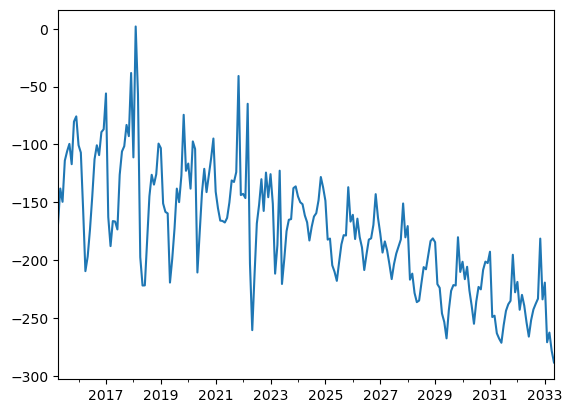

In [55]:
df_algeria_and_forecast.water_availability.plot()

In [56]:
# Bhopal
daily_water_demand_mld_bhopal = daily_water_demand_lcd * df_bhopal_and_forecast['population'] * 10**(-6)
df_bhopal_and_forecast['water_availability'] = df_bhopal_and_forecast.daily_water_volume - daily_water_demand_mld_bhopal

<Axes: >

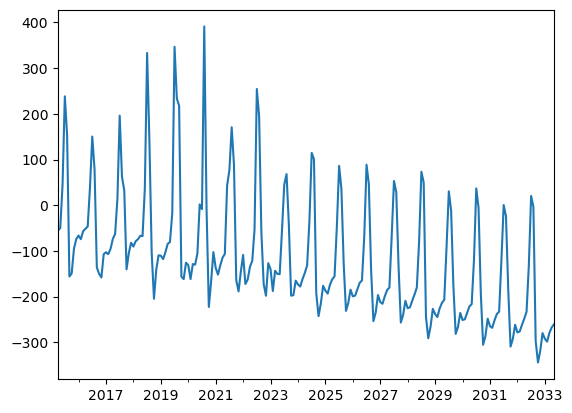

In [57]:
df_bhopal_and_forecast.water_availability.plot()